In [8]:
import numpy as np
import a5_utils as a5u
import UZ_utils
import matplotlib.pyplot as plt
import cv2
import math
import os
import random


plt.rcParams['figure.figsize'] = [8, 4]

# 1 b

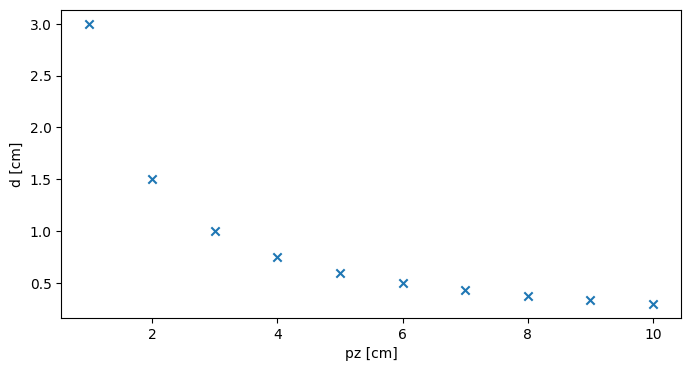

In [9]:

def firstB():
    f = 0.25 # in cm
    T = 12 # in cm

    pz = np.linspace(1, 10, 10)
    # print(pz)
    d = f * T / pz

    plt.scatter(pz, d, marker="x")
    plt.xlabel("pz [cm]")
    plt.ylabel("d [cm]")
    plt.show()


firstB()

# 2 b

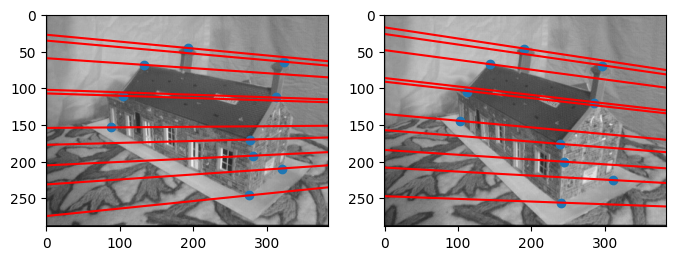

In [10]:

def fundamental_matrix(pts):
    # print("pts")
    # print(pts)

    pts1 = pts[:, 0:2]
    pts2 = pts[:, 2:4]
    # print("pts1, pts2")
    # print(pts1, pts2)

    pts1Nor, T1 = a5u.normalize_points(pts1)
    pts2Nor, T2 = a5u.normalize_points(pts2)
    # print("pts1Nor, pts2Nor")
    # print(pts1Nor, pts2Nor)


    # Postopek opisan v nalogi

    A = np.zeros((pts1.shape[0], 9))

    for i in range (A.shape[0]):
        xL = pts1Nor[i, 0]
        yL = pts1Nor[i, 1]

        xR = pts2Nor[i, 0]
        yR = pts2Nor[i, 1]
        
        A[i, 0] = xL * xR
        A[i, 1] = yL * xR
        A[i, 2] = xR
        A[i, 3] = xL * yR
        A[i, 4] = yL * yR
        A[i, 5] = yR
        A[i, 6] = xL
        A[i, 7] = yL
        A[i, 8] = 1
    
    # print("A")
    # print(A)

    
    U, D, VT = np.linalg.svd(A)
    V = VT.T
    # print("V:")
    # print(V)

    v9 = V[:, -1]
    Fdash = np.reshape(v9, (3,3))
    # print("v9")
    # print(v9)
    # print("Fdash")
    # print(Fdash)


    U, D, VT = np.linalg.svd(Fdash)
    # print("D")
    # print(D)

    D[-1] = 0
    D = np.diag(D)
    # print("U, D, VT")
    # print(U, D, VT)
    Fdash = np.matmul(np.matmul(U, D), VT)
    # print("Fdash post reconstruction")
    # print(Fdash)
    


    U, D, VT = np.linalg.svd(Fdash)
    V = VT.T

    eL = V[:,2] / V[2,2]
    eR = U[:,2] / U[2,2]
    # print("eL, eR")
    # print(eL, eR)


    




    F = np.matmul(np.matmul(T2.T, Fdash), T1)
    # print("F")
    # print(F)

    return F, eL, eR






    

def twoA():
    house_points = np.loadtxt(".\data\epipolar\house_points.txt")
    # print(house_points)

    F, eL, eR = fundamental_matrix(house_points)

    house1 = UZ_utils.imread_gray(".\data\epipolar\house1.jpg")
    house2 = UZ_utils.imread_gray(".\data\epipolar\house2.jpg")


    pts = house_points
    pts1 = pts[:, 0:2]
    pts2 = pts[:, 2:4]

    plt.subplot(1, 2, 1)
    plt.imshow(house1, cmap="gray")
    plt.scatter(pts[:,0], pts[:,1])

    plt.subplot(1, 2, 2)
    plt.imshow(house2, cmap="gray")
    plt.scatter(pts[:,2], pts[:,3])


    plt.subplot(1, 2, 2)
    for ix, row in enumerate(pts1):
        row = np.append(row, 1)
        row = row.reshape(3,1)
        # print(row)
        lineEq = np.matmul(F, row)
        a5u.draw_epiline(lineEq, *house2.shape)
    
    plt.subplot(1, 2, 1)
    for ix, row in enumerate(pts2):
        row = np.append(row, 1)
        row = row.reshape(3,1)
        # print(row)
        lineEq = np.matmul(F.T, row)
        a5u.draw_epiline(lineEq, *house1.shape)





twoA()

# 2 c

In [11]:


def reprojection_error(F, pt1, pt2):
    """
    pt1 and pt2 arent in homogenous coordinates. It will just be easier this way.
    """

    pt1homo = np.append(pt1, 1)
    pt2homo = np.append(pt2, 1)

    lineEq1 = np.matmul(F.T, pt2homo)
    lineEq2 = np.matmul(F, pt1homo)

    distance1 = abs(sum(lineEq1 * pt1homo)) / (math.sqrt(lineEq1[0]**2 + lineEq1[1]**2))
    distance2 = abs(sum(lineEq2 * pt2homo)) / (math.sqrt(lineEq2[0]**2 + lineEq2[1]**2))

    avg_dist = (distance1 + distance2) / 2

    return avg_dist




def twoC():
    house_points = np.loadtxt(".\data\epipolar\house_points.txt")
    # print(house_points)

    F, eL, eR = fundamental_matrix(house_points)

    
    
    p1 = [85, 233]
    p2 = [67, 219]

    err = reprojection_error(F, p1, p2)
    print(err)
    
    
    # house1 = UZ_utils.imread_gray(".\data\epipolar\house1.jpg")
    # house2 = UZ_utils.imread_gray(".\data\epipolar\house2.jpg")


    pts = house_points
    pts1 = pts[:, 0:2]
    pts2 = pts[:, 2:4]

    total_err = 0
    for i, _ in enumerate(pts1):
        total_err += reprojection_error(F, pts1[i,:], pts2[i,:])

    avg_err = total_err / pts1.shape[0]
    print(avg_err)


twoC()

0.14674365570452158
0.33091336980541597


# 3 a

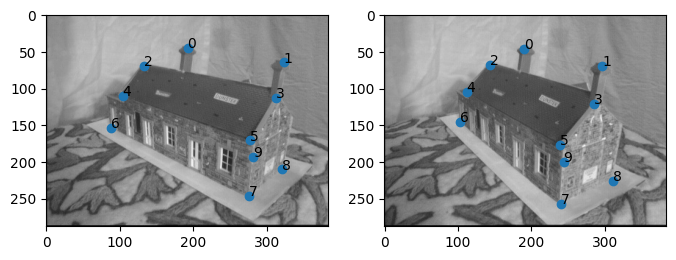

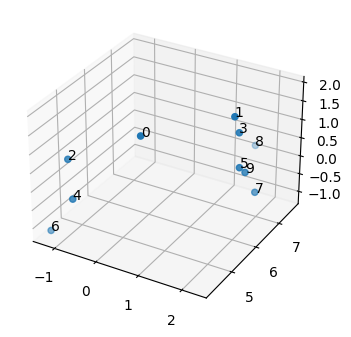

In [12]:

def cross_prod_matrix_non_homog(vec):
    A = np.zeros((3,3))

    ax = vec[0]
    ay = vec[1]
    az = 1

    A[0,1] = -az
    A[0,2] = ay
    A[1,0] = az
    A[1,2] = -ax
    A[2,0] = -ay
    A[2,1] = ax

    return A


def triangulate(pts1, pts2, P1, P2):

    T = np.zeros((3,3))
    T[0,0] = -1
    T[1,2] = -1
    T[2,1] = 1




    ptsTriang = np.zeros((pts1.shape[0], 3))

    for ix in range(pts1.shape[0]):
        pt1 = pts1[ix, :]
        pt2 = pts2[ix, :]

        pt1_shear = cross_prod_matrix_non_homog(pt1)
        # print("pt1")
        # print(pt1)
        # print("pt1_shear")
        # print(pt1_shear)

        Atop = np.matmul(pt1_shear, P1)
        # print("Atop")
        # print(Atop)


        pt2_shear = cross_prod_matrix_non_homog(pt2)
        Abot = np.matmul(pt2_shear, P2)

        A = np.vstack((Atop, Abot))
        # print(Atop, Abot, A)
        # print()

        U, D, VT = np.linalg.svd(A)
        V = VT.T

        v_least = V[:, -1]
        coords = v_least[0:3] / v_least[3]

        ptsTriang[ix, :] = np.matmul(T, coords.T)

    return ptsTriang


def threeA():
    P1 = np.loadtxt(".\data\epipolar\house1_camera.txt").reshape(3, 4)
    P2 = np.loadtxt(".\data\epipolar\house2_camera.txt").reshape(3, 4)
    # print("P1, P2")
    # print(P1, P2)

    house_points = np.loadtxt(".\data\epipolar\house_points.txt")
    # print(house_points)

    house1 = UZ_utils.imread_gray(".\data\epipolar\house1.jpg")
    house2 = UZ_utils.imread_gray(".\data\epipolar\house2.jpg")


    pts = house_points
    pts1 = pts[:, 0:2]
    pts2 = pts[:, 2:4]

    ptsTriang = triangulate(pts1, pts2, P1, P2)








    plt.subplot(1, 2, 1)
    plt.imshow(house1, cmap="gray")
    plt.scatter(pts[:,0], pts[:,1])

    for i in range(pts.shape[0]):
        plt.text(*pts[i, 0:2], str(i))

    plt.subplot(1, 2, 2)
    plt.imshow(house2, cmap="gray")
    plt.scatter(pts[:,2], pts[:,3])

    for i in range(pts.shape[0]):
        plt.text(*pts[i, 2:4], str(i))

    # print(ptsTriang)



    fig = plt.figure()

    # plt.plot(ptsTriang[:,0], ptsTriang[:,1], ptsTriang[:,2])

    ax = plt.axes(projection ='3d')
    ax.scatter(ptsTriang[:,0], ptsTriang[:,1], ptsTriang[:,2])

    for i in range(ptsTriang.shape[0]):
        ax.text(*ptsTriang[i, :], str(i))

    # ax.set_xlabel("x")
    # ax.set_ylabel("y")

    # plt.zlabel("z")


    plt.show()









threeA()





